In [ ]:
# A first order attempt to pull cosmics out of SM SIF data

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from astropy.io import fits
import astroscrappy

In [3]:
from matplotlib.colors import LogNorm

In [4]:
import scipy.ndimage as ndimage

Grab one dataset

In [95]:
#sourcefile=("../../datasets/sif_fits/2015-07-03/SIF_PROCESSING_CCD_ROW_2_SM1_OBMT_START_52911899999459900_CDP_NONE.fits")
sourcefile=("../../datasets/sif_fits/2015-04-03/SIF_PROCESSING_CCD_ROW_3_SM1_OBMT_START_45028212999616700_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2017-09-11/SIF_PROCESSING_CCD_ROW_1_SM1_OBMT_START_122099768999236700_CDP_NONE.fits")

hdulist = fits.open(sourcefile)
hdulist.info()
# Gaia SM images are binned by 2 in AC direction( hence AC dim = 990 )
# Gaia SM images are binned by 2 in AL direction( hence AL dim = 2543 )

Filename: ../../datasets/sif_fits/2015-04-03/SIF_PROCESSING_CCD_ROW_3_SM1_OBMT_START_45028212999616700_CDP_NONE.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      19   (990, 2542)   int16 (rescales to uint16)   
  1  AC_COORDINATES  ImageHDU        11   (990, 2542)   int16   
  2  AC_BINNING  ImageHDU        11   (990, 2542)   int16   
  3  TDI_TTAG    ImageHDU         9   (2542,)   int64   
  4  CI_BIT      ImageHDU         9   (2542,)   uint8   
  5  TDI_GATE    ImageHDU         9   (2542,)   int16   
  6  IDLE_BIT    ImageHDU         9   (2542,)   uint8   
  7  TEST_PATTERN_BIT  ImageHDU         9   (2542,)   uint8   
  8  OPEXIT_BIT  ImageHDU         9   (2542,)   uint8   
  9  STATUS_BIT  ImageHDU         9   (2542,)   int32   
 10  OBMT        ImageHDU         9   (2542,)   int64   


In [96]:
gain = 3.853  # just using the one from the BAM SIFs - this could be totally different!
readnoise = 2*gain

In [97]:
source = hdulist[0].data
hdulist.close()

(2542, 990)


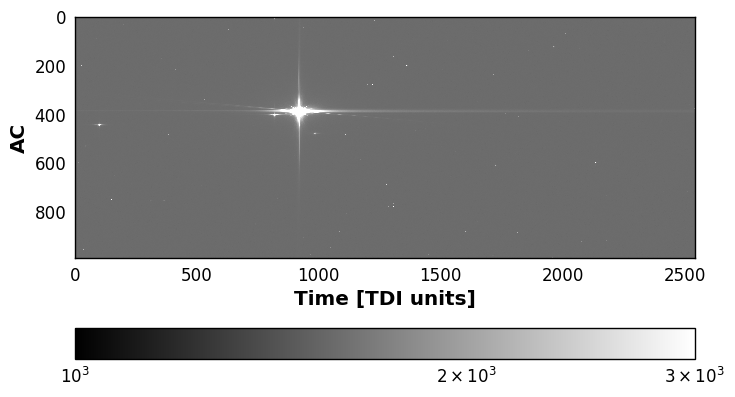

In [98]:
print(source.shape)

image=np.flip(np.rot90(source,1),0) # this should follow the normal gaia convention
plt.xlabel('Time [TDI units]')
plt.ylabel('AC')
plt.imshow(image, cmap='gray', norm=LogNorm(),vmin=1e3,vmax=3e3)
plt.colorbar(orientation="horizontal")
plt.grid(False)

A simple attempt at scrappy - let's just see what happens...

In [99]:
(mask,clean) = astroscrappy.detect_cosmics(source, gain=gain, verbose=True,
                                           inmask=None, satlevel=65535, readnoise=readnoise, sepmed=False,
                                           cleantype='medmask', fsmode='median')

Starting 4 L.A.Cosmic iterations
Iteration 1:
784 cosmic pixels this iteration
Iteration 2:
173 cosmic pixels this iteration
Iteration 3:
114 cosmic pixels this iteration
Iteration 4:
70 cosmic pixels this iteration


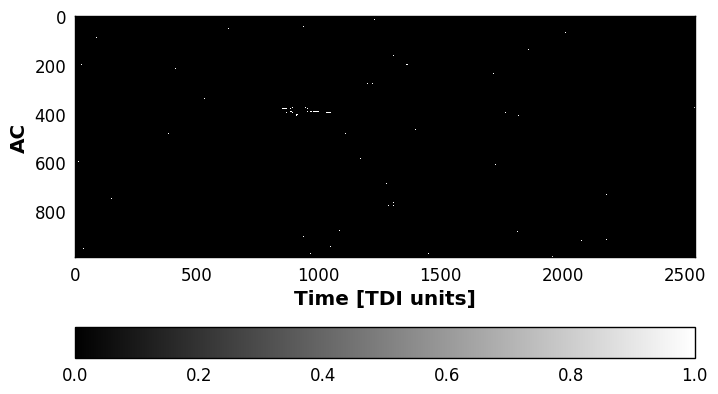

In [113]:
image=np.flip(np.rot90(mask,1),0) # this should follow the normal gaia convention
plt.xlabel('Time [TDI units]')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
plt.colorbar(orientation="horizontal")
plt.grid(False)
plt.savefig("mask.pdf")

Okay, it seems that several cosmics have been detected.

HOWEVER: There is a clear clustering of detected pixels that is exactly at the source location - this is bad, they are most likely not cosmics. Let's run our cosmic analysis to check for wierd behaviour...

In [101]:
cosmics = (source*gain - clean)*mask

In [102]:
# labelling

(labels, ntracks) = ndimage.measurements.label(mask,structure=(np.ones((3,3))))
#(labels, ntracks) = ndimage.measurements.label(mask,structure=[[0,1,0],[1,1,1],[0,1,0]])
#(labels, ntracks) = ndimage.measurements.label(dilmask,structure=[[0,1,0],[1,1,1],[0,1,0]])

print("Number of events:", ntracks)

Number of events: 252


In [103]:
# object extraction based on labels

events = ndimage.measurements.find_objects(labels)

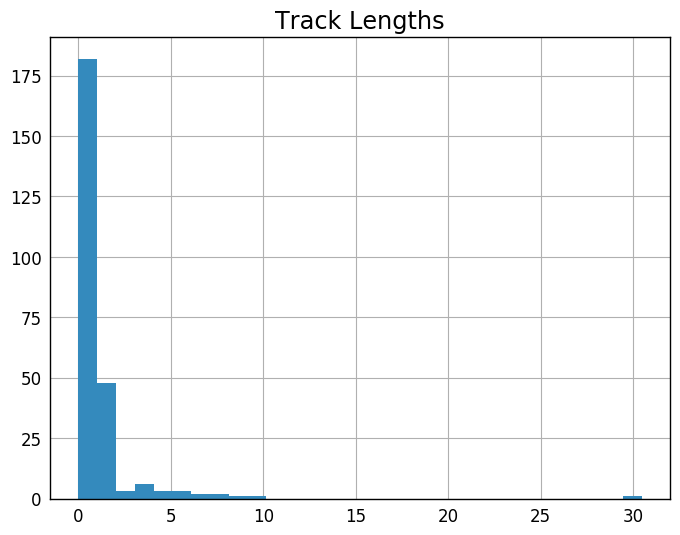

In [108]:
# Extract track lengths. We can use the slices for that

lengths = np.zeros(ntracks)

for ii in range(ntracks):
    dx = (events[ii][0].stop-events[ii][0].start-1)/3. # to roughly account for the binning. Unit would be AC-Pixels
    dy = events[ii][1].stop-events[ii][1].start-1       # need to subtract 1, since single pixel cosmics would then have
                                                        # a length of sqrt(2)
    lengths[ii] = np.sqrt(dx**2 + dy**2)

lhist = plt.hist(lengths,30)
plt.title("Track Lengths")

In [105]:
# Extract track electron count

events_e = np.zeros(ntracks)

for ii in range(ntracks):
    events_e[ii] = np.sum(cosmics[events[ii]])

Min: 450.800980469
Max: 582334.733223


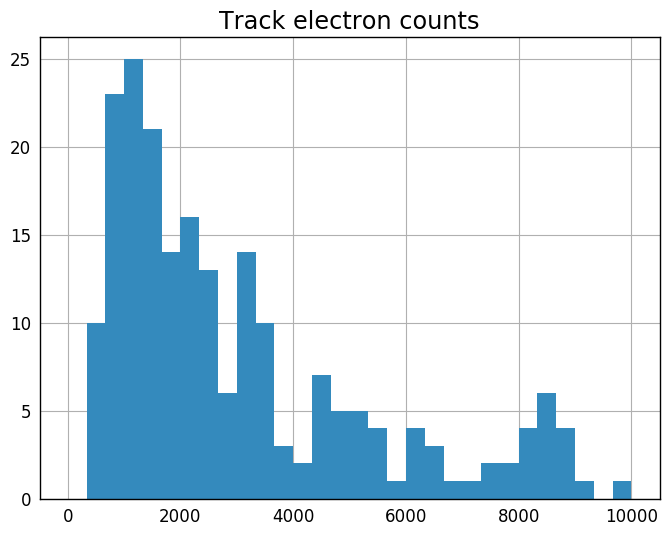

In [106]:
#ehist = plt.hist(events_e,1000)
ehist = plt.hist(events_e,30,range=(0,10000)) # cut off the maximum energies - I want a comparison with
                                              # the simulator validation presentation
plt.title("Track electron counts")
print('Min:',np.min(events_e))
print('Max:',np.max(events_e))

Interesting. Previous extraction for simulator validations of SM data (their slide 53) shows a similar distribution.

Seems like the fake cosmics generated by the source didn't hurt too much?

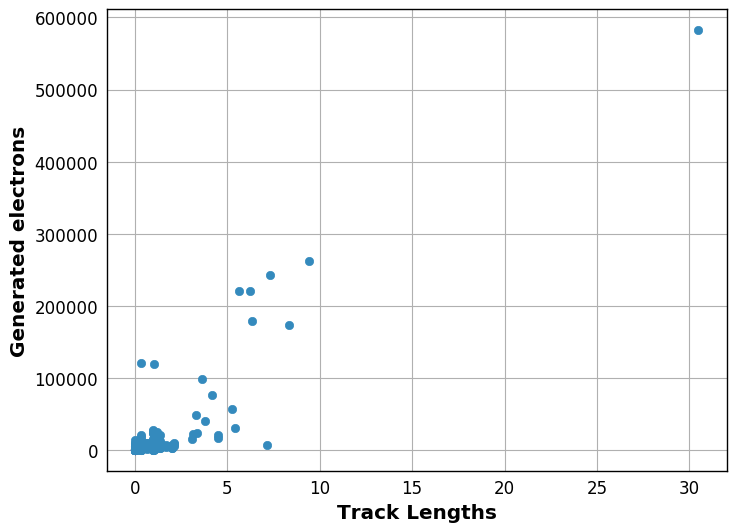

In [94]:
plt.scatter(lengths, events_e)
plt.xlabel("Track Lengths")
plt.ylabel("Generated electrons")

Not seeing much here.

In general, the extraction doesn't seem very problematic. I still need to extract more parameters for a proper analysis (gain, readnoise) but scrappy seems to be doing reasonable work here. 

Aside from the very saturated region, which generates a few fake cosmics, things seem to be working fairly well. Perhaps we should mask a region around the core ahead of time (all saturated pixels are already ignored)?